In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 7)
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 12})
import tensorflow as tf

import gpflow as gpf
from gpflow.config import default_float
from gpflow.models import GPR, SVGP
from gpflow.kernels import RBF, Matern52
from gpflow.likelihoods import Gaussian
from gpflow.inducing_variables import InducingPoints

from gpflux.layers.basis_functions.random_fourier_features import RandomFourierFeatures
from gpflux.sampling.kernel_with_feature_decomposition import KernelWithFeatureDecomposition

In [2]:
# experiment parameters that are the same for both sets of experiments
X_interval = [0.14, 0.5]  # interval where training points live
noise_variance = 1e-3  # noise variance
number_of_test_samples = 1024  # number of evaluation points for prediction
number_of_function_samples = 20  # number of function samples
number_of_basis_functions = 2000  # number of basis functions for approximate kernels
lengthscale = 0.1  # lengthscale for the kernel (which is fixed and not learned in all experiments)

# experiment parameters that differ across both sets of experiments
number_of_train_samples = [4, 1000]  # number of training points
number_of_inducing_points = [4, 8]  # number of inducing points for SVGP models

# kernel class
kernel_class = Matern52  # set alternatively kernel_class = RBF

# plotting configuration
x_lim = [0.0, 1.0]
y_lim = [-3.5, 3.5]

In [3]:
# generate training data and evaluation points for both sets of experiments
kernel = kernel_class(lengthscales=lengthscale)
X, y, X_star = [], [], []

for i in range(2):

    # training points
    X.append(np.linspace(start=X_interval[0], stop=X_interval[1], num=number_of_train_samples[i]))

    # training targets
    kXX = kernel.K(X[i][..., None])
    kXX_plus_noise_var = tf.linalg.set_diag(kXX, tf.linalg.diag_part(kXX) + noise_variance)
    lXX = tf.linalg.cholesky(kXX_plus_noise_var)
    y.append(tf.matmul(lXX, tf.random.normal([number_of_train_samples[i], 1], dtype=X[i].dtype))[..., 0])

    # evaluation points
    X_star.append(np.linspace(start=x_lim[0], stop=x_lim[1], num=number_of_test_samples))

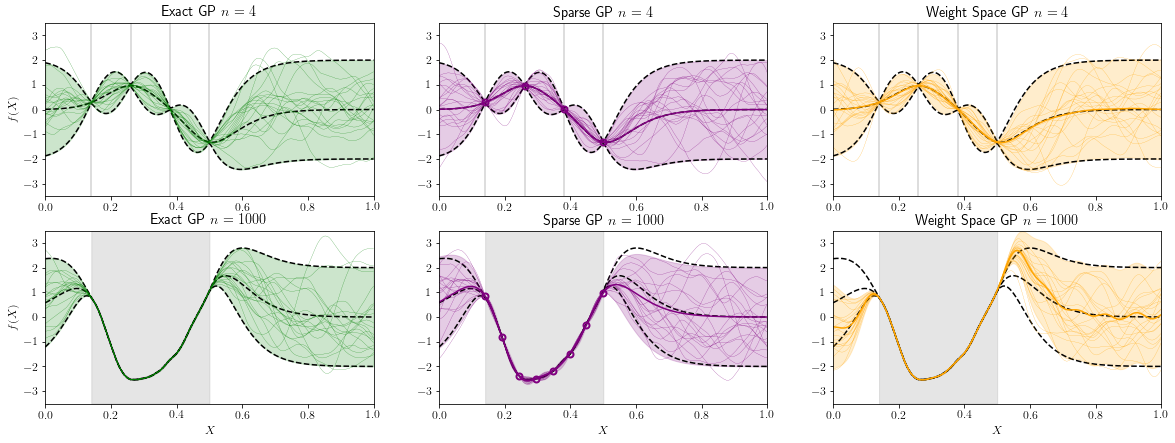

In [5]:
# create subplot frame
# 1st row: experiments with few training examples, 2nd row: experiments with many training examples
# 1st col: exact Gaussian process regression (GPR), 2nd col: sparse variational Gaussian process model (SVGP),
# 3rd col: weight space approximation of the exact GPR posterior with random Fourier features
fig, axs = plt.subplots(2, 3)


# iterate through both experiments (i=1 refers to few and i=2 to many training samples)
for experiment in range(2):


    # titles and y-axis label
    axs[experiment, 0].set_title('Exact GP $n=' + str(number_of_train_samples[experiment]) + '$')
    axs[experiment, 1].set_title('Sparse GP $n=' + str(number_of_train_samples[experiment]) + '$')
    axs[experiment, 2].set_title('Weight Space GP $n=' + str(number_of_train_samples[experiment]) + '$')
    axs[experiment, 0].set_ylabel('$f(X)$')
    if experiment == 1:
        axs[experiment, 0].set_xlabel('$X$')
        axs[experiment, 1].set_xlabel('$X$')
        axs[experiment, 2].set_xlabel('$X$')


    # plot training point locations X  
    for i in range(3):
        if experiment == 0:  # as vertical lines for the first set of experiments with few trainig samples
            axs[experiment, i].vlines(X[experiment], ymin=y_lim[0], ymax=y_lim[1], colors='lightgrey')
        else:  # as fill plot for the second set of experiments with many training samples
            axs[experiment, i].fill_between(X[experiment], y_lim[0], y_lim[1], color='gray', alpha=0.2)
        axs[experiment, i].set_xlim(x_lim)
        axs[experiment, i].set_ylim(y_lim)


    # create the GPR "ground-truth" model
    gpr_model = GPR(
        data=(X[experiment][..., None], y[experiment][..., None]),
        kernel=kernel_class(lengthscales=lengthscale),
        noise_variance=noise_variance
    )

    # predict mean and variance and draw function samples
    f_mean, f_var = gpr_model.predict_f(X_star[experiment][..., None])
    f_samples = gpr_model.predict_f_samples(X_star[experiment][..., None], num_samples=number_of_function_samples)
    f_mean_plus_2std = f_mean + 2 * f_var ** 0.5
    f_mean_minus_2std = f_mean - 2 * f_var ** 0.5

    # plot mean and std lines from the GPR model as "ground truth"
    for i in range(3):
        axs[experiment, i].plot(X_star[experiment], f_mean[..., 0], linestyle='--', color='black')
        axs[experiment, i].plot(X_star[experiment], f_mean_minus_2std[..., 0], linestyle='--', color='black')
        axs[experiment, i].plot(X_star[experiment], f_mean_plus_2std[..., 0], linestyle='--', color='black')

    # visualize GPR model predictions
    axs[experiment, 0].fill_between(
        X_star[experiment], 
        f_mean_minus_2std[..., 0], 
        f_mean_plus_2std[..., 0], 
        color='green', 
        alpha=0.2
    )
    for i in range(f_samples.shape[0]):
        axs[experiment, 0].plot(X_star[experiment], f_samples[i, ..., 0], color='green', linewidth=0.2)


    # create the SVGP model
    if experiment == 0:  # inducing points equal the training data for the first experiment with few train samples
        Z = X[experiment].copy()[..., None]
    else:  # inducing points are randomly chosen for the second experiment with many train samples
        Z = np.linspace(X_interval[0], X_interval[1], number_of_inducing_points[experiment])[..., None]
    svgp_model = SVGP(
        kernel=kernel_class(lengthscales=lengthscale),
        likelihood=Gaussian(variance=noise_variance),
        inducing_variable=InducingPoints(Z=Z)
    )
    gpf.set_trainable(svgp_model.kernel, False)
    gpf.set_trainable(svgp_model.likelihood, False)
    gpf.set_trainable(svgp_model.inducing_variable, False)  # inducing point locations are fixed!
    def optimize_model_with_scipy(model):
        optimizer = gpf.optimizers.Scipy()
        optimizer.minimize(
            model.training_loss_closure((X[experiment][..., None], y[experiment][..., None])),
            variables=model.trainable_variables,
            method="l-bfgs-b",
            options={"disp": False, "maxiter": 10000},
        )
    optimize_model_with_scipy(svgp_model)

    # predict mean and variance and draw function samples
    f_mean, f_var = svgp_model.predict_f(X_star[experiment][..., None])
    f_samples = svgp_model.predict_f_samples(X_star[experiment][..., None], num_samples=number_of_function_samples)
    f_mean_plus_2std = f_mean + 2 * f_var ** 0.5
    f_mean_minus_2std = f_mean - 2 * f_var ** 0.5

    # visualize SVGP model predictions
    axs[experiment, 1].fill_between(
        X_star[experiment], 
        f_mean_minus_2std[..., 0],
        f_mean_plus_2std[..., 0], 
        color='purple',
        alpha=0.2
    )
    for i in range(f_samples.shape[0]):
        axs[experiment, 1].plot(X_star[experiment], f_samples[i, ..., 0], color='purple', linewidth=0.2)
    axs[experiment, 1].plot(X_star[experiment], f_mean[..., 0], color='purple')

    # visualize predictions at inducing point locations
    Z = svgp_model.inducing_variable.Z
    q_mu, _ = svgp_model.predict_f(Z)
    axs[experiment, 1].plot(Z[..., 0], q_mu[..., 0], 'o', mfc='none', markeredgewidth=2, color='purple')


    # create exact GPR model with approximated kernel
    feature_functions = RandomFourierFeatures(
        kernel=kernel_class(lengthscales=lengthscale),
        output_dim=number_of_basis_functions,
        dtype=default_float()
    )
    feature_coefficients = np.ones((number_of_basis_functions, 1), dtype=default_float())
    kernel = KernelWithFeatureDecomposition(
        kernel=None,
        feature_functions=feature_functions,
        feature_coefficients=feature_coefficients
    )
    gpr_model = GPR(
        data=(X[experiment][..., None], y[experiment][..., None]),
        kernel=kernel,
        noise_variance=noise_variance
    )

    # predict mean and variance and draw function samples
    f_mean, f_var = gpr_model.predict_f(X_star[experiment][..., None])
    f_samples = gpr_model.predict_f_samples(X_star[experiment][..., None], num_samples=number_of_function_samples)
    f_mean_plus_2std = f_mean + 2 * f_var ** 0.5
    f_mean_minus_2std = f_mean - 2 * f_var ** 0.5

    # visualize GPR model predictions
    axs[experiment, 2].fill_between(
        X_star[experiment], 
        f_mean_minus_2std[..., 0],
        f_mean_plus_2std[..., 0], 
        color='orange', 
        alpha=0.2
    )
    for i in range(f_samples.shape[0]):
        axs[experiment, 2].plot(X_star[experiment], f_samples[i, ..., 0], color='orange', linewidth=0.2)
    axs[experiment, 2].plot(X_star[experiment], f_mean[..., 0], color='orange')


# show the plot
plt.show()